# CIA Factbook Using SQLite and Python

In this project, we are using a SQLite database, factbook.db, from the CIA World Factbook, which contains statistics about all of the countries on Earth.

In [1]:
# imports and connect to the database
import sqlite3
import pandas as pd

conn = sqlite3.connect('factbook.db')
cursor = conn.cursor

In [2]:
# info on the tables in the database
q1 = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
# create query to return first 5 rows of the facts table
q2 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


## Outliers

Let's look at the data for any outliers.

In [4]:
# create query to return the following:
# min population, max population, min pop growth, max pop growth
q3 = '''SELECT MIN(population) min_pop, MAX(population) max_pop, 
MIN(population_growth) min_pop_growth, MAX(population_growth) max_pop_growth
FROM facts;'''
pd.read_sql_query(q3, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


In [5]:
# look at the country(ies) with 0 population
q4 = '''SELECT * FROM facts
WHERE population == (SELECT MIN(population) FROM facts);'''
pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [6]:
# look at the country(ies) with max population
q5 = '''SELECT * FROM facts
WHERE population == (SELECT MAX(population) FROM facts);'''
pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


There is one country, Antarctica, that has zero population and no population growth.  While this country is physically large, no one lives there.

The other "country" with maximum population is actually the world.  It appears that the population is the total population of all of the countries, and the calculated rates for population growth, birth, and deaths are for the whole world.

Depending on the analyses we perform later, we may need to exclude one or both of these.

## Histograms

Let's first look at the histograms for population, population growth, birth rate, and death rate.

/dataquest/system/env/python3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2885: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6849df7b8>,
      dtype=object)

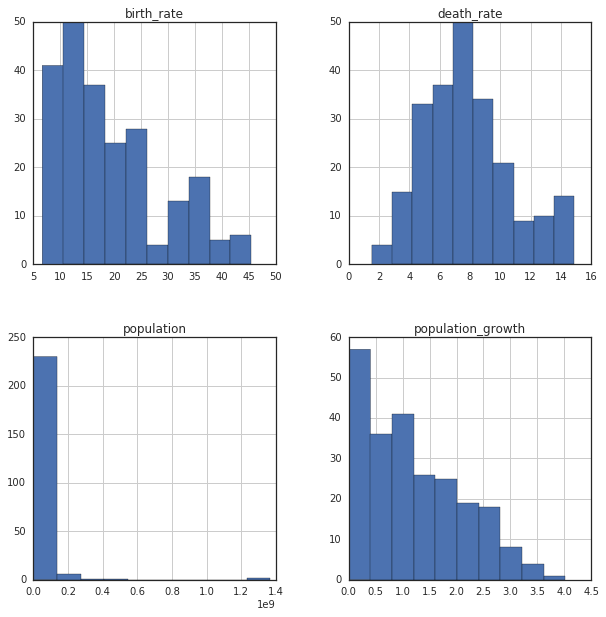

In [7]:
# create histograms for pop, pop_growth, birth_rate, death_rate
# ignore Antarctica and the World in these visualizations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q6 = '''SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts);'''

pd.read_sql_query(q6, conn).hist(ax=ax)

## Population Density

Next, let's look at population density across countries.

In [8]:
# create query for highest population density countries
q7 = '''SELECT name, CAST(population as float)/CAST(area as float) density
FROM facts
ORDER BY density DESC
LIMIT 15;'''
pd.read_sql_query(q7, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff68e0314e0>],
      dtype=object)

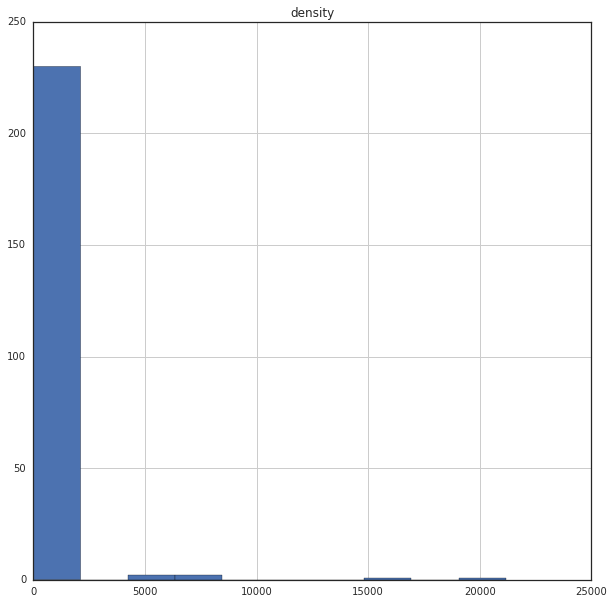

In [9]:
# create histogram of population density
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q8 = '''SELECT CAST(population as float)/CAST(area as float) density
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts);'''

pd.read_sql_query(q8, conn).hist(ax=ax)

## Water versus Land

Let's look at the highest ratios of water to land and which countries have more water than land.

In [10]:
# create query for highest water/land ratio countries
q9 = '''SELECT name, CAST(area_water as float)/CAST(area_land as float) water_ratio
FROM facts
ORDER BY water_ratio DESC
LIMIT 15;'''
pd.read_sql_query(q9, conn)

,name,water_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


From the above, we can see that only two countries, British Indian Ocean Territory and Virgin Islands, have more water than land (because the ratio is greater than one).

The next highest ratios, which are less than one, include several islands, which seems reasonable.  Interestingly, there are some non-island countries included here as well, such as Guinea-Bissau, a country in West Africa, and Netherlands, a country in Western Europe.  Both of these countries have a large amount of the country that is at or near sea level and have borders that include more of the ocean.